In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score
import sklearn.preprocessing as preprocessing
from sklearn.decomposition import PCA
from sklearn.grid_search import GridSearchCV
from datetime import datetime
import seaborn as sns
import warnings
import utility

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
train = train.drop(train[train.Y == 90].index)

In [4]:
train.describe(include='all')

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
count,877982,877982,877982,877982,877982,877982,877982,877982.000000,877982.000000
unique,389229,39,879,7,10,17,23191,NaN,NaN
top,2011-01-01 00:01:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Friday,SOUTHERN,NONE,800 Block of BRYANT ST,NaN,NaN
freq,185,174885,60013,133723,157174,526757,26533,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-122.422763,37.767035
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.025285,0.024165
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-122.513642,37.707879
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-122.432952,37.752427
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-122.416420,37.775421
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-122.406959,37.784368


In [5]:
TRAIN_COUNT = len(train)

In [6]:
merged = train.iloc[:, :].append(test.iloc[:, 1:])

In [9]:
dates = merged.Dates.apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
merged['Hour'] = dates.apply(lambda x: x.hour)
merged['Year'] = dates.apply(lambda x: x.year)
merged['Month'] = dates.apply(lambda x: x.month)
merged['IsNight'] = merged.Hour.apply(lambda x : 1 if (x >= 23 and x <= 24) or (x >= 0 and x <= 5) else 0)
merged['IsWinter'] = merged.Month.apply(lambda x : 1 if (x > 0 and x <= 2) or x == 12 else 0)
merged['IsSummer'] = merged.Month.apply(lambda x : 1 if (x >= 6 and x <= 8) else 0)
merged['IsSpring'] = merged.Month.apply(lambda x : 1 if (x >= 3 and x <= 5) else 0)
merged['IsAutumn'] = merged.Month.apply(lambda x : 1 if (x >= 9 and x <= 11) else 0)

In [12]:
merged = pd.concat([merged, pd.get_dummies(merged.PdDistrict, prefix='Distr_')], axis=1)
merged = pd.concat([merged, pd.get_dummies(merged.DayOfWeek, prefix='DoW_')], axis=1)

In [31]:
scaler = preprocessing.StandardScaler()
scaler = scaler.fit(merged[:TRAIN_COUNT].loc[:, ['X', 'Y']])
merged[['X', 'Y']] = scaler.transform(merged.loc[:, ['X', 'Y']])

In [38]:
pca = PCA(n_components=2)
pca = pca.fit(merged[:TRAIN_COUNT].loc[:, ['X', 'Y']])
pca_locations  = pca.transform(merged.loc[:, ['X', 'Y']])
merged = merged.assign(PCA_X = pca_locations[:, 0], PCA_Y = pca_locations[:, 1])

In [33]:
merged.head().T

,0,1,2,3,4
Address,OAK ST / LAGUNA ST,OAK ST / LAGUNA ST,VANNESS AV / GREENWICH ST,1500 Block of LOMBARD ST,100 Block of BRODERICK ST
Category,WARRANTS,OTHER OFFENSES,OTHER OFFENSES,LARCENY/THEFT,LARCENY/THEFT
Dates,2015-05-13 23:53:00,2015-05-13 23:53:00,2015-05-13 23:33:00,2015-05-13 23:30:00,2015-05-13 23:30:00
DayOfWeek,Wednesday,Wednesday,Wednesday,Wednesday,Wednesday
Descript,WARRANT ARREST,TRAFFIC VIOLATION ARREST,TRAFFIC VIOLATION ARREST,GRAND THEFT FROM LOCKED AUTO,GRAND THEFT FROM LOCKED AUTO
PdDistrict,NORTHERN,NORTHERN,NORTHERN,NORTHERN,PARK
Resolution,"ARREST, BOOKED","ARREST, BOOKED","ARREST, BOOKED",NONE,NONE
X,-0.123732,-0.123732,-0.0632738,-0.167381,-0.631787
Y,0.313018,0.313018,1.38135,1.40031,0.186493
Hour,23,23,23,23,23


In [44]:
cov = np.cov(merged[:TRAIN_COUNT].loc[:, ['X', 'Y']].T)
cov

array([[ 1.00000114,  0.15417475],
       [ 0.15417475,  1.00000114]])

In [45]:
eugvalues, eugvectors = np.linalg.eig(cov)
eugvalues, eugvectors

(array([ 0.84582639,  1.15417589]), array([[-0.70710678, -0.70710678],
        [ 0.70710678, -0.70710678]]))

In [46]:
np.dot(eugvectors[0], eugvectors[1])

0.0

(-4, 3)

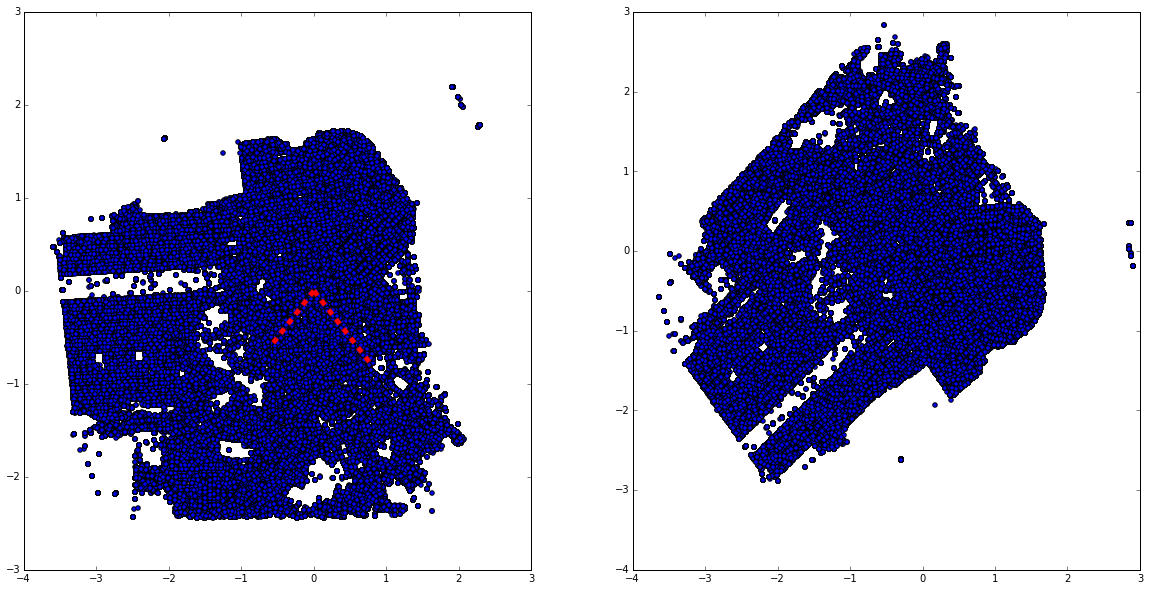

In [49]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(121)
ax.scatter(merged[:TRAIN_COUNT].X, merged[:TRAIN_COUNT].Y)

for i in range(0, len(eugvalues)):
    x = eugvectors[i][0]*eugvalues[i]
    y = eugvectors[i][1]*eugvalues[i]
    ax.plot([0,x], [0, y], '--', linewidth=5, color='r')
    
ax = fig.add_subplot(122)
ax.scatter(merged[:TRAIN_COUNT].PCA_X, merged[:TRAIN_COUNT].PCA_Y)    

ax.set_xlim(-4, 3)
ax.set_ylim(-4, 3)

In [59]:
features = ['PCA_X', 'PCA_Y', 'Year', 'Month', 'Hour', 'IsNight', 'IsSummer', 'IsWinter', 'IsAutumn', 'IsSpring']
features = features + [c for c in merged.columns if 'Distr_' in c]
features = features + [c for c in merged.columns if 'DoW_' in c]
features

['PCA_X',
 'PCA_Y',
 'Year',
 'Month',
 'Hour',
 'IsNight',
 'IsSummer',
 'IsWinter',
 'IsAutumn',
 'IsSpring',
 'Distr__BAYVIEW',
 'Distr__CENTRAL',
 'Distr__INGLESIDE',
 'Distr__MISSION',
 'Distr__NORTHERN',
 'Distr__PARK',
 'Distr__RICHMOND',
 'Distr__SOUTHERN',
 'Distr__TARAVAL',
 'Distr__TENDERLOIN',
 'DoW__Friday',
 'DoW__Monday',
 'DoW__Saturday',
 'DoW__Sunday',
 'DoW__Thursday',
 'DoW__Tuesday',
 'DoW__Wednesday']

([<matplotlib.axis.YTick at 0x10bbf5eb8>,
 <a list of 27 Text yticklabel objects>)

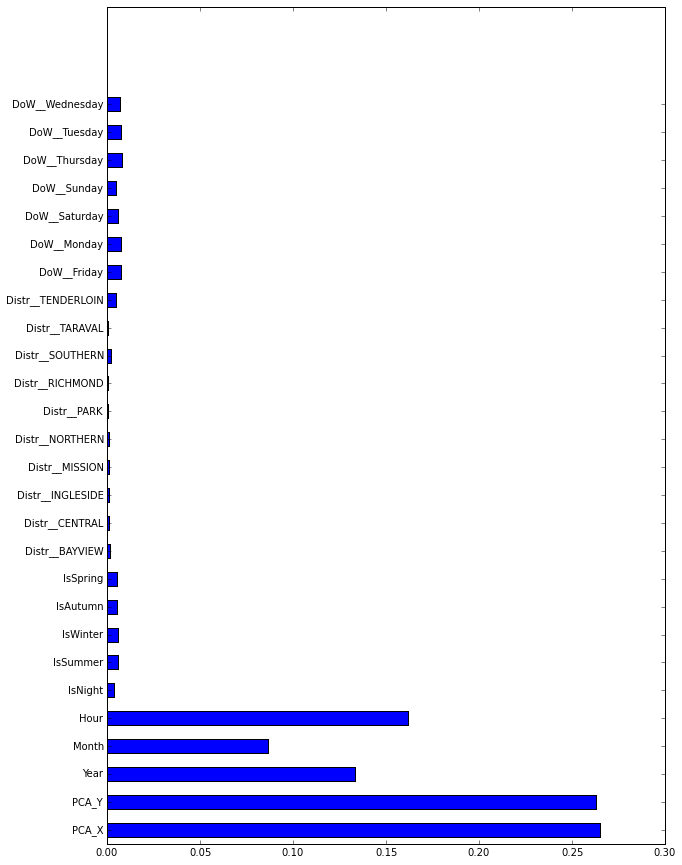

In [61]:
trn = merged[:TRAIN_COUNT].loc[:, features]
rf = ExtraTreesClassifier(max_depth=None)
rf = rf.fit(trn, train.Category)
fig = plt.figure(figsize=(10,15))
ax = fig.add_subplot(111)
pos = np.arange(len(trn.columns)) + 0.5 
rects = ax.barh(pos, rf.feature_importances_,
                     align='center',
                     height=0.5, color='blue')
plt.yticks(pos, trn.columns)

In [64]:
trn = merged[:TRAIN_COUNT].loc[:, features]
param_grid = dict(max_depth=[5, 10, 15, 20, 50], min_samples_leaf=[5, 10, 25, 50])
model = ExtraTreesClassifier()
grid = GridSearchCV(model, param_grid, cv=5, scoring='log_loss', n_jobs = -1)
grid.fit(trn, train.Category)
grid.grid_scores_

[mean: -2.64885, std: 0.07371, params: {'max_depth': 5, 'min_samples_leaf': 5},
 mean: -2.65803, std: 0.07482, params: {'max_depth': 5, 'min_samples_leaf': 10},
 mean: -2.64842, std: 0.04631, params: {'max_depth': 5, 'min_samples_leaf': 25},
 mean: -2.66005, std: 0.06283, params: {'max_depth': 5, 'min_samples_leaf': 50},
 mean: -2.71768, std: 0.10410, params: {'max_depth': 10, 'min_samples_leaf': 5},
 mean: -2.64610, std: 0.07521, params: {'max_depth': 10, 'min_samples_leaf': 10},
 mean: -2.68973, std: 0.12215, params: {'max_depth': 10, 'min_samples_leaf': 25},
 mean: -2.75522, std: 0.15732, params: {'max_depth': 10, 'min_samples_leaf': 50},
 mean: -2.87860, std: 0.28030, params: {'max_depth': 15, 'min_samples_leaf': 5},
 mean: -2.85122, std: 0.18061, params: {'max_depth': 15, 'min_samples_leaf': 10},
 mean: -2.85717, std: 0.22872, params: {'max_depth': 15, 'min_samples_leaf': 25},
 mean: -2.76559, std: 0.09853, params: {'max_depth': 15, 'min_samples_leaf': 50},
 mean: -3.39801, std: 0

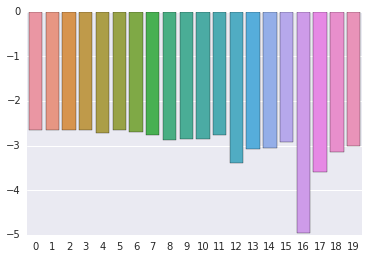

In [66]:
sns.barplot(list(range(0, len(grid.grid_scores_))), [r[1] for r in grid.grid_scores_])

In [88]:
features = ['PCA_X', 'PCA_Y', 'Year', 'Month', 'Hour']
#features = features + [c for c in merged.columns if 'Distr_' in c]
#features = features + [c for c in merged.columns if 'DoW_' in c]
features

['PCA_X', 'PCA_Y', 'Year', 'Month', 'Hour']

([<matplotlib.axis.YTick at 0x1614521d0>,
 <a list of 5 Text yticklabel objects>)

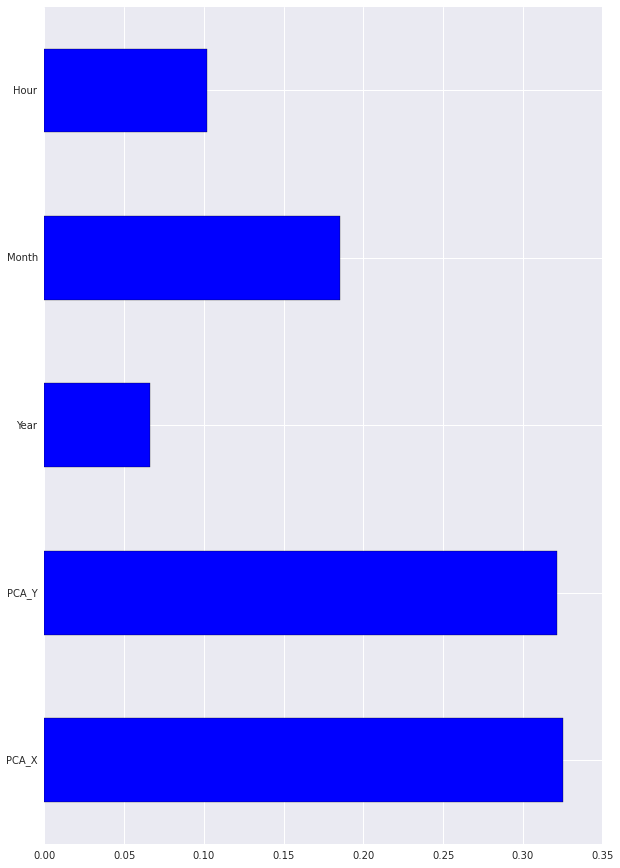

In [89]:
trn = merged[:TRAIN_COUNT].loc[:, features]
rf = ExtraTreesClassifier(max_depth=None)
rf = rf.fit(trn, train.Category)
fig = plt.figure(figsize=(10,15))
ax = fig.add_subplot(111)
pos = np.arange(len(trn.columns)) + 0.5 
rects = ax.barh(pos, rf.feature_importances_,
                     align='center',
                     height=0.5, color='blue')
plt.yticks(pos, trn.columns)

In [71]:
trn = merged[:TRAIN_COUNT].loc[:, features]
param_grid = dict(max_depth=[5, 10, 15, 20], min_samples_leaf=[5, 10, 25])
model = ExtraTreesClassifier()
grid = GridSearchCV(model, param_grid, cv=5, scoring='log_loss', n_jobs = -1)
grid.fit(trn, train.Category)
grid.grid_scores_

[mean: -2.69225, std: 0.05571, params: {'max_depth': 5, 'min_samples_leaf': 5},
 mean: -2.67760, std: 0.04674, params: {'max_depth': 5, 'min_samples_leaf': 10},
 mean: -2.71916, std: 0.06838, params: {'max_depth': 5, 'min_samples_leaf': 25},
 mean: -2.71063, std: 0.10626, params: {'max_depth': 5, 'min_samples_leaf': 50},
 mean: -2.91787, std: 0.17160, params: {'max_depth': 10, 'min_samples_leaf': 5},
 mean: -3.04890, std: 0.31053, params: {'max_depth': 10, 'min_samples_leaf': 10},
 mean: -3.07094, std: 0.36323, params: {'max_depth': 10, 'min_samples_leaf': 25},
 mean: -2.96761, std: 0.18279, params: {'max_depth': 10, 'min_samples_leaf': 50},
 mean: -4.13098, std: 1.10775, params: {'max_depth': 15, 'min_samples_leaf': 5},
 mean: -3.92100, std: 0.89395, params: {'max_depth': 15, 'min_samples_leaf': 10},
 mean: -3.79178, std: 0.98683, params: {'max_depth': 15, 'min_samples_leaf': 25},
 mean: -3.96572, std: 1.20769, params: {'max_depth': 15, 'min_samples_leaf': 50},
 mean: -8.20522, std: 4

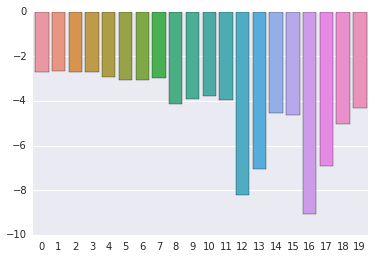

In [72]:
sns.barplot(list(range(0, len(grid.grid_scores_))), [r[1] for r in grid.grid_scores_])

In [90]:
trn = merged[:TRAIN_COUNT].loc[:, features]
model = ExtraTreesClassifier()
scores = cross_val_score(model, trn, train.Category, cv=5, scoring='log_loss')
print(scores)

[-24.13384558 -27.50345931 -29.11749224 -28.84412963 -29.97480824]


In [83]:
trn = merged[:TRAIN_COUNT].loc[:, features]
model = LogisticRegression()
model = model.fit(trn, train.Category)
predicted = model.predict_proba(merged[TRAIN_COUNT:].loc[:, features])

In [84]:
def saveTestDf(categories, path):
    predicted = pd.DataFrame(categories, columns = rf.classes_, index = test.index)
    predicted.index.name = 'Id'
    predicted.to_csv(path, sep=',', index=True)

In [85]:
saveTestDf(predicted, 'log_regr_1.csv')